In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
english_file = '/content/drive/MyDrive/MP/dataset/mr-en/train.en'
marathi_file = '/content/drive/MyDrive/MP/dataset/mr-en/train.mr'

In [ ]:
with open(english_file, 'r') as file:
    english_sentences = file.readlines()
with open(marathi_file, 'r') as file:
    marathi_sentences = file.readlines()


english_sentences = [sentence.rstrip('\n') for sentence in english_sentences]
marathi_sentences = [sentence.rstrip('\n') for sentence in marathi_sentences]

In [ ]:
def is_valid_tokens(sentence , vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

valid_sentence_indicies = []
for index in range(len(english_sentences)):
    marathi_sentence, english_sentence = marathi_sentences[index], english_sentences[index]
    if is_valid_tokens(marathi_sentence, marathi_vocabulary) \
      and is_valid_tokens(english_sentence , english_vocabulary):
        valid_sentence_indicies.append(index)

In [ ]:
x = [english_sentences[i] for i in valid_sentence_indicies]
y = [marathi_sentences[i] for i in valid_sentence_indicies]

In [ ]:
import pandas as pd
dataset =  pd.DataFrame({"marathi":marathi_sentences[:300000], "english":english_sentences[:300000] })
dataset.info()

In [ ]:
dataset.to_csv('/content/drive/MyDrive/MP/data.csv' , index = False )

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/NMT-Transformer/data_mr-en.csv')
dataset.head()

,Marathi,English
0,"आज आसियान आणि भारत, आसियानचे राजनीतिक- सुरक्षा...","Today, ASEAN and India enjoy multi-faceted coo..."
1,आसियान राष्ट्र समुहातील देशांशी भारताचे उत्तम ...,"For us in India, ASEANs continuance in this ro..."
2,[ ७ पानांवरील चित्र],We need to put faith in his reminders.
3,"दरम्यान, गुजरात निवडणूकीचा प्रचार आता शिगेला प...",Presently elections are being held in Gujarat.
4,यामुळे सौर ऊर्जा क्षेत्रातल्या संशोधनाला आणि त...,This will aim to pool research and technologic...


In [ ]:
text_pairs = []

for i in range(dataset.shape[0]) :
    mar = str(dataset["Marathi"][i])
    eng = "[start] " + str(dataset["English"][i]) + " [end]"
    text_pairs.append((mar,eng))

In [ ]:
len(text_pairs)

200000

In [ ]:
train_sample_size = len(text_pairs) - int(0.1*len(text_pairs))
train_pairs = text_pairs[:train_sample_size]
test_pairs = text_pairs[train_sample_size:]

print("Total pairs :", len(text_pairs))
print("Train pairs :", len(train_pairs))
print("Test pairs :", len(test_pairs))

Total pairs : 200000
Train pairs : 180000
Test pairs : 20000


In [ ]:
strip_chars = string.punctuation + "|"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace('""', "")

vocab_size = 70000
sequence_length = 30
batch_size = 128

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [ ]:
mar_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

In [ ]:
train_mar_texts = [pair[0] for pair in train_pairs]
train_eng_texts = [pair[1] for pair in train_pairs]
mar_vectorization.adapt(train_mar_texts)
eng_vectorization.adapt(train_eng_texts)

In [ ]:
import json

# Get the vocabulary
mar_vocab = mar_vectorization.get_vocabulary()
eng_vocab = eng_vectorization.get_vocabulary()


# Save the vocabulary
with open('/content/drive/MyDrive/NMT-Transformer/vectorizers/mar_vocab.json', 'w') as f:
    json.dump(mar_vocab, f)
with open('/content/drive/MyDrive/NMT-Transformer/vectorizers/eng_vocab.json', 'w') as f:
    json.dump(eng_vocab, f)


In [ ]:
import json


vocab_size = 70000
sequence_length = 30
batch_size = 128


# Load the vocabulary
with open('/content/drive/MyDrive/NMT-Transformer/vectorizers/mar_vocab.json', 'r') as f:
    mar_vocab = json.load(f)
with open('/content/drive/MyDrive/NMT-Transformer/vectorizers/eng_vocab.json', 'r') as f:
    eng_vocab = json.load(f)

# Create a TextVectorization layer with the loaded vocabulary
mar_vectorization = TextVectorization(vocabulary=mar_vocab,output_mode="int", output_sequence_length=sequence_length)
eng_vectorization = TextVectorization(vocabulary=eng_vocab,output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization)

In [ ]:
def format_dataset(mar, eng):
    mar = mar_vectorization(mar)
    eng = eng_vectorization(eng)
    return ({"encoder_inputs": mar, "decoder_inputs": eng[:, :-1],}, eng[:, 1:])

In [ ]:
def make_dataset(pairs):
    mar_texts, eng_texts = zip(*pairs)
    mar_texts = list(mar_texts)
    eng_texts = list(eng_texts)
    dataset = tf.data.Dataset.from_tensor_slices((mar_texts, eng_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

In [ ]:
train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [ ]:
for inputs, targets in train_ds.take(2):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 30)
inputs["decoder_inputs"].shape: (128, 30)
targets.shape: (128, 30)
inputs["encoder_inputs"].shape: (128, 30)
inputs["decoder_inputs"].shape: (128, 30)
targets.shape: (128, 30)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2  = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
embed_dim = 512
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

In [ ]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

In [ ]:
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 512)            3585536   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                         0                                       
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                      

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"d_model": self.d_model.numpy(), "warmup_steps": self.warmup_steps}

In [ ]:
learning_rate = CustomSchedule(latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

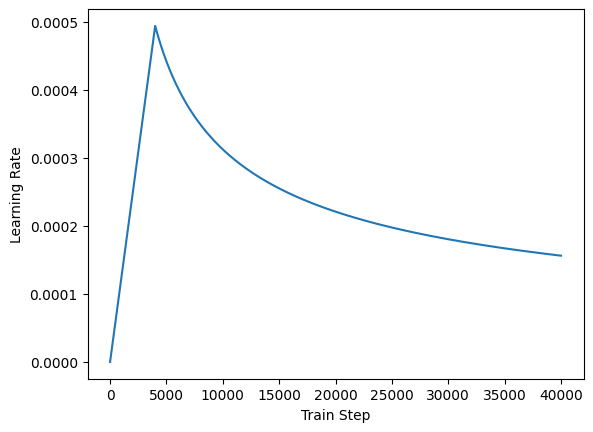

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint_filepath = '/content/drive/MyDrive/NMT-Transformer/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

csv_logger = callbacks.CSVLogger('/content/drive/MyDrive/NMT-Transformer/training_log.csv' , append=True)


backup_callback = callbacks.BackupAndRestore(backup_dir="/content/drive/MyDrive/NMT-Transformer/backup" ,
                                             delete_checkpoint=False)

In [ ]:
epochs = 30
transformer.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
transformer.load_weights('/content/drive/MyDrive/NMT-Transformer/checkpoint/')

In [ ]:
history = transformer.fit(train_ds,
                epochs=epochs,
                validation_data=test_ds ,
                callbacks=[
                      early_stopping ,
                      model_checkpoint_callback ,
                      csv_logger ,
                      backup_callback ])

Epoch 1/30
1407/1407 [==============================] - 896s 624ms/step - loss: 6.8255 - accuracy: 0.1977 - val_loss: 5.3312 - val_accuracy: 0.2766
Epoch 2/30
1407/1407 [==============================] - 873s 621ms/step - loss: 5.0150 - accuracy: 0.3038 - val_loss: 4.6646 - val_accuracy: 0.3312
Epoch 3/30
1407/1407 [==============================] - 867s 616ms/step - loss: 4.5488 - accuracy: 0.3452 - val_loss: 4.3673 - val_accuracy: 0.3575
Epoch 4/30
1407/1407 [==============================] - 906s 644ms/step - loss: 4.1906 - accuracy: 0.3812 - val_loss: 4.1769 - val_accuracy: 0.3778
Epoch 5/30
1407/1407 [==============================] - 876s 623ms/step - loss: 3.8705 - accuracy: 0.4149 - val_loss: 4.1196 - val_accuracy: 0.3872
Epoch 6/30
1407/1407 [==============================] - 850s 604ms/step - loss: 3.6013 - accuracy: 0.4448 - val_loss: 4.1486 - val_accuracy: 0.3871
Epoch 7/30
1407/1407 [==============================] - 863s 613ms/step - loss: 3.3623 - accuracy: 0.4726 - val_

In [ ]:
history = transformer.fit(train_ds,
                epochs=epochs,
                validation_data=test_ds ,
                callbacks=[
                      early_stopping ,
                      model_checkpoint_callback ,
                      csv_logger ,
                      backup_callback ])

Epoch 8/20
1407/1407 [==============================] - 1070s 680ms/step - loss: 3.1962 - accuracy: 0.4917 - val_loss: 4.0161 - val_accuracy: 0.4009
Epoch 9/20
1407/1407 [==============================] - 957s 680ms/step - loss: 2.9679 - accuracy: 0.5231 - val_loss: 4.1267 - val_accuracy: 0.3964
Epoch 10/20
1407/1407 [==============================] - 919s 653ms/step - loss: 2.7810 - accuracy: 0.5512 - val_loss: 4.2554 - val_accuracy: 0.3903
Epoch 11/20
1407/1407 [==============================] - 918s 653ms/step - loss: 2.6294 - accuracy: 0.5758 - val_loss: 4.3769 - val_accuracy: 0.3878
Epoch 12/20
1407/1407 [==============================] - 926s 658ms/step - loss: 2.4970 - accuracy: 0.5983 - val_loss: 4.4971 - val_accuracy: 0.3821
Epoch 13/20
1407/1407 [==============================] - 919s 653ms/step - loss: 2.3724 - accuracy: 0.6196 - val_loss: 4.6123 - val_accuracy: 0.3800
Epoch 14/20
1407/1407 [==============================] - 957s 680ms/step - loss: 2.2569 - accuracy: 0.6399 

In [ ]:
history = transformer.fit(train_ds,
                epochs=epochs,
                validation_data=test_ds ,
                callbacks=[
                      early_stopping ,
                      model_checkpoint_callback ,
                      csv_logger ,
                      backup_callback ])

Epoch 11/20
1407/1407 [==============================] - 995s 658ms/step - loss: 2.6488 - accuracy: 0.5711 - val_loss: 4.2840 - val_accuracy: 0.3925
Epoch 12/20
1407/1407 [==============================] - 884s 628ms/step - loss: 2.4903 - accuracy: 0.5998 - val_loss: 4.4392 - val_accuracy: 0.3855
Epoch 13/20
1407/1407 [==============================] - 927s 659ms/step - loss: 2.3541 - accuracy: 0.6231 - val_loss: 4.5842 - val_accuracy: 0.3829
Epoch 14/20
1407/1407 [==============================] - 926s 658ms/step - loss: 2.2375 - accuracy: 0.6435 - val_loss: 4.7294 - val_accuracy: 0.3829
Epoch 15/20
 374/1407 [======>.......................] - ETA: 10:12 - loss: 2.1109 - accuracy: 0.6644

In [ ]:
transformer.save('/content/drive/MyDrive/NMT-Transformer/V1-50k-106M.h5')

In [ ]:
transformer.load_model('/content/drive/MyDrive/MP/V1-50k-106M.h5')

In [ ]:
import os
def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the figure if save_dir and filename are provided
    if save_dir and filename:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path)
        print(f"Plots saved as '{save_path}'")

    plt.show()
plot_loss_and_accuracy(history ,"/content/drive/MyDrive/NMT-Transformer", "V1-50k-106M_trainloss.png" )

In [ ]:
eng_vocab = eng_vectorization.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
max_decoded_sentence_length = 20

In [ ]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = mar_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = eng_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [ ]:
sample  = random.choice(train_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('marathi - ' , input_sentence )
print('english' )
print('Ground Truth : ', sample[1])
print('Macenge Translation : ' , translated )

Tamil -  भाजपचे राष्ट्रीय अध्यक्ष अमित शहा सध्या लातुर दौऱ्यावर आहेत.
Hindi
Ground Truth :  [start] BJP National President Amit Shah has already been touring the State. [end]
Machine Translation :  [start] bjp national president amit shah has also been appointed as the chief minister of the state [end]


In [ ]:
import re
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/NMT-Transformer/comparisons2.xlsx')

predictions = []

def remove_start_end(sentence):
    output = re.sub(r'\[start\]', '', sentence)
    output = re.sub(r'\[end\]', '', output)
    return output.strip()

for index, row in df.iterrows():
    input_sentence = str(row['Marathi']).strip()
    translated = remove_start_end(decode_sequence(input_sentence))
    # translated = decode_sequence(input_sentence)
    print('Marathi- ' , input_sentence )
    print('Macenge Translation : ' , translated )
    predictions.append(translated)

df['Transformer-Prediction'] = predictions

df.to_excel('/content/drive/MyDrive/NMT-Transformer/output_comparisons2.xlsx', index=False)

Marathi -  खर्च कोण करणार
Machine Translation :  who will pay
Marathi -  अधिवेशनातील कार्यक्रम
Machine Translation :  conference of students
Marathi -  मायलिनला धक्का पोहोचल्याचा परिणाम मेंदूकडून शरीराच्या अन्य भागांकडे पोहोचणाऱ्या संदेशांवर होतो
Machine Translation :  the main reason that the death of a tree can cause of the death toll is expected to be able
Marathi -  इतका खंबीरपणा कुठुन मिळवला असेल त्याने
Machine Translation :  so that would be a man of wisdom
Marathi -  हा महोत्सव सर्वांसाठी विनामूल्य ठेवण्यात आला आहे
Machine Translation :  the festival is free for all
Marathi -  या प्रकल्पाबरोबरच सरकारने रातले जल विद्युत प्रकल्प येथिल हजारो युवकांना रोजगारही मिळणार आहे
Machine Translation :  the minister said that the water scheme is being provided by youth power through the government of india to provide
Marathi -  मुंबई – गोव्यातील भाजपचे मुख्यमंत्री मनोहर पर्रिकर यांची प्रकृती पुन्हा खालावली आहे
Machine Translation :  mumbai bjp chief minister manohar parrikar resigned from his

In [ ]:
sample  = random.choice(test_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('marathi - ' , input_sentence )
print('english' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

Tamil -  आंध्र आणि ओडिशात अनेक ठिकाणी मुसळधार पाऊस कोसळत आहे.
Hindi
Ground Truth :  [start] Heavy rain is expected in some districts of Odisha and Andhra Pradesh. [end]
Machine Translation :  [start] heavy rains are lashed parts of andhra pradesh and vidarbha [end]
